# Ensemble reduction

This tutorial will explore ensemble reduction (also known as ensemble selection) using `xscen`. This will use pre-computed annual mean temperatures from `xclim.testing`.

In [1]:
from xclim.testing import open_dataset

import xscen as xs

datasets = {
    "ACCESS": "EnsembleStats/BCCAQv2+ANUSPLIN300_ACCESS1-0_historical+rcp45_r1i1p1_1950-2100_tg_mean_YS.nc",
    "BNU-ESM": "EnsembleStats/BCCAQv2+ANUSPLIN300_BNU-ESM_historical+rcp45_r1i1p1_1950-2100_tg_mean_YS.nc",
    "CCSM4-r1": "EnsembleStats/BCCAQv2+ANUSPLIN300_CCSM4_historical+rcp45_r1i1p1_1950-2100_tg_mean_YS.nc",
    "CCSM4-r2": "EnsembleStats/BCCAQv2+ANUSPLIN300_CCSM4_historical+rcp45_r2i1p1_1950-2100_tg_mean_YS.nc",
    "CNRM-CM5": "EnsembleStats/BCCAQv2+ANUSPLIN300_CNRM-CM5_historical+rcp45_r1i1p1_1970-2050_tg_mean_YS.nc",
}

for d in datasets:
    ds = open_dataset(datasets[d]).isel(lon=slice(0, 4), lat=slice(0, 4))
    ds = xs.climatological_mean(ds, window=30, periods=[[1981, 2010], [2021, 2050]])
    datasets[d] = xs.compute_deltas(ds, reference_horizon="1981-2010")
    datasets[d].attrs["cat:id"] = d  # Required by build_reduction_data
    datasets[d].attrs["cat:xrfreq"] = "AS-JAN"

INFO:xclim:Fetching remote file: EnsembleStats/BCCAQv2+ANUSPLIN300_ACCESS1-0_historical+rcp45_r1i1p1_1950-2100_tg_mean_YS.nc
INFO:xclim:Fetching remote file md5: EnsembleStats/BCCAQv2+ANUSPLIN300_ACCESS1-0_historical+rcp45_r1i1p1_1950-2100_tg_mean_YS.nc.md5
INFO:xclim:Fetching remote file: EnsembleStats/BCCAQv2+ANUSPLIN300_BNU-ESM_historical+rcp45_r1i1p1_1950-2100_tg_mean_YS.nc
INFO:xclim:Fetching remote file md5: EnsembleStats/BCCAQv2+ANUSPLIN300_BNU-ESM_historical+rcp45_r1i1p1_1950-2100_tg_mean_YS.nc.md5
INFO:xclim:Fetching remote file: EnsembleStats/BCCAQv2+ANUSPLIN300_CCSM4_historical+rcp45_r1i1p1_1950-2100_tg_mean_YS.nc
INFO:xclim:Fetching remote file md5: EnsembleStats/BCCAQv2+ANUSPLIN300_CCSM4_historical+rcp45_r1i1p1_1950-2100_tg_mean_YS.nc.md5
INFO:xclim:Fetching remote file: EnsembleStats/BCCAQv2+ANUSPLIN300_CCSM4_historical+rcp45_r2i1p1_1950-2100_tg_mean_YS.nc
INFO:xclim:Fetching remote file md5: EnsembleStats/BCCAQv2+ANUSPLIN300_CCSM4_historical+rcp45_r2i1p1_1950-2100_tg_mea

## Preparing the data

Ensemble reduction is built upon climate indicators that are relevant to represent the ensemble's variability for a given application. In this case, we'll use the mean temperature delta between 2021-2050 and 1981-2010.

However, the functions implemented in `xclim.ensembles._reduce` require a very specific 2-D DataArray of dimensions "realization" and "criteria". That means that all the variables need to be combined and renamed, and that all dimensions need to be stacked together.

`xs.build_reduction_data` can be used to prepare the data for ensemble reduction. Its arguments are:

- `datasets` (dict, list)
- `xrfreqs` are the unique frequencies of the indicators.
- `horizons` is used to instruct on which horizon(s) to build the data from.

Because a simulation could have multiple datasets (in the case of multiple frequencies), an attempt will be made to decipher the ID and frequency from the metadata.

In [2]:
data = xs.build_reduction_data(
    datasets=datasets,
    xrfreqs=["AS-JAN"],
    horizons=["2021-2050"],
)

data

/expl7/pbourg/mambaforge/envs/espor/lib/python3.10/site-packages/xarray/core/common.py:620: FutureWarning: Updating MultiIndexed coordinate 'criteria' would corrupt indices for other variables: ['lat', 'time', 'lon']. This will raise an error in the future. Use `.drop_vars({'criteria', 'lat', 'lon', 'time'})` before assigning new coordinate values.


<xarray.DataArray 'values' (realization: 5, criteria: 16)>
array([[1.6385803, 1.6387024, 1.6386108, 1.6383972, 1.6400146, 1.6401978,
        1.6411133, 1.6411743, 1.6436768, 1.6435242, 1.6429443, 1.6429138,
        1.6479797, 1.6470337, 1.6461182, 1.6454468],
       [2.0663452, 2.0625305, 2.059143 , 2.056244 , 2.0645447, 2.0613098,
        2.0582886, 2.0549316, 2.0631104, 2.0596619, 2.056549 , 2.0528564,
        2.0624084, 2.0589905, 2.055359 , 2.0518494],
       [1.6872864, 1.690033 , 1.6922913, 1.6943359, 1.6863403, 1.689331 ,
        1.6921997, 1.6947937, 1.685852 , 1.6888733, 1.6918335, 1.6954346,
        1.6836548, 1.6868286, 1.6904602, 1.6944885],
       [1.6043091, 1.6021423, 1.6007996, 1.5988159, 1.6131592, 1.611084 ,
        1.6099854, 1.6082764, 1.6217651, 1.620697 , 1.6195679, 1.618042 ,
        1.6308289, 1.6300964, 1.629364 , 1.62854  ],
       [1.3090515, 1.3095093, 1.3098145, 1.3091736, 1.3128052, 1.3133545,
        1.3131714, 1.3131714, 1.3164062, 1.3165588, 1.316864 , 1.3173828,
        1.3200073, 1.3203735, 1.3208923, 1.3215027]], dtype=float32)
Coordinates:
  * realization  (realization) <U8 'ACCESS' 'BNU-ESM' ... 'CCSM4-r2' 'CNRM-CM5'
  * criteria     (criteria) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
Attributes:
    long_name:  criteria for ensemble selection

The number of criteria corresponds to: `indicators x horizons x longitude x latitude`, but criteria that are purely NaN across all realizations are removed.

Note that `xs.spatial_mean` could have been used prior to calling that function to remove the spatial dimensions.

## Selecting a reduced ensemble

<div class="alert alert-info"> <b>NOTE</b>
    
Ensemble reduction in `xscen` is built upon `xclim.ensembles`. For more information on basic usage and available methods, [please consult their documentation](https://xclim.readthedocs.io/en/stable/notebooks/ensembles-advanced.html).
</div>

Ensemble reduction through `xscen.reduce_ensemble` consists in a simple call to `xclim`. The arguments are:
- `data`, which is the 2D DataArray that is created by using `xs.build_reduction_data`.
- `method` is either `kkz` or `kmeans`. See the link above for further details on each technique.
- `kwargs` is a dictionary of arguments to send to the method chosen.

In [3]:
selected, clusters, fig_data = xs.reduce_ensemble(
    data=data, method="kmeans", kwargs={"method": {"n_clusters": 3}}
)

The method always returns 3 outputs (selected, clusters, fig_data):
- `selected` is a DataArray of dimension 'realization' listing the selected simulations.
- `clusters` (kmeans only) groups every realization in their respective clusters in a python dictionary.
- `fig_data` (kmeans only) can be used to call `xclim.ensembles.plot_rsqprofile(fig_data)`

In [4]:
selected

<xarray.DataArray 'realization' (realization: 3)>
array(['ACCESS', 'BNU-ESM', 'CNRM-CM5'], dtype='<U8')
Coordinates:
  * realization  (realization) <U8 'ACCESS' 'BNU-ESM' 'CNRM-CM5'
Attributes:
    axis:     E

In [5]:
# To see the clusters in more details
clusters

{0: <xarray.DataArray 'realization' (realization: 3)>
 array(['ACCESS', 'CCSM4-r1', 'CCSM4-r2'], dtype='<U8')
 Coordinates:
   * realization  (realization) <U8 'ACCESS' 'CCSM4-r1' 'CCSM4-r2'
 Attributes:
     axis:     E,
 1: <xarray.DataArray 'realization' (realization: 1)>
 array(['BNU-ESM'], dtype='<U8')
 Coordinates:
   * realization  (realization) <U8 'BNU-ESM'
 Attributes:
     axis:     E,
 2: <xarray.DataArray 'realization' (realization: 1)>
 array(['CNRM-CM5'], dtype='<U8')
 Coordinates:
   * realization  (realization) <U8 'CNRM-CM5'
 Attributes:
     axis:     E}

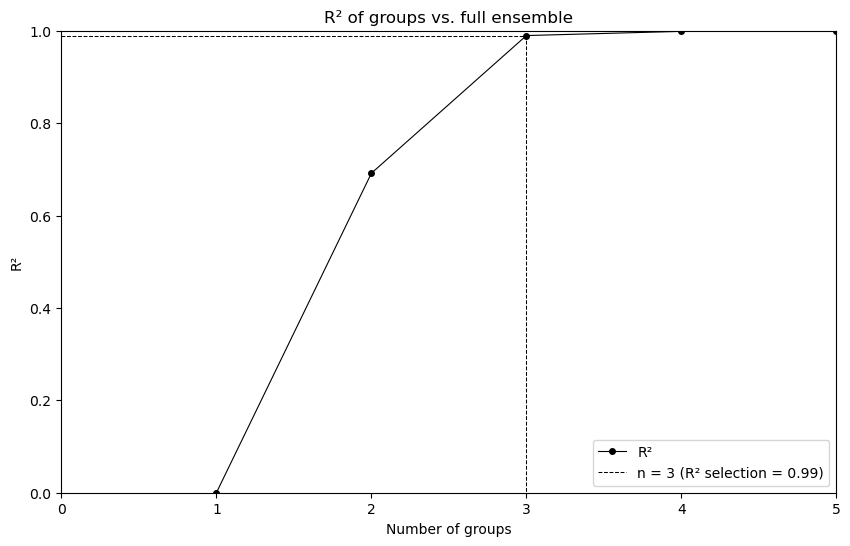

In [6]:
from xclim.ensembles import plot_rsqprofile

plot_rsqprofile(fig_data)